# Global Minimum Variance Portfolios

## Background

Continuing our discussions around portfolio construction, we will begin to build from the Efficient Frontier to the Global Minimum Variance (GMV) Portfolio.

Let's define what the GMV is: it is simply the portfolio along the frontier that has the minumum portfolio volatility.  We will look at how this porfolio is constructed, how to improve this construction and how it performs over time.

In [195]:
# collapse
# Setup / Imports

import numpy as np
import pandas as pd
from pandas_datareader import data

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import norm

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
print("Setup Complete")

Setup Complete


## The Data

We will utilize the 9 sector ETFs from State Street to construct our GMV portfolio.  We will compare these results to the cap-weighted 'SPY' as well as to the EW allocation across all 9 ETFs. Here are the sector ETFs:

* XLY: Consumer Discretionary Sector   
* XLP: Consumer Staples Sector  
* XLE: Energy Sector  
* XLF: Financial Sector 
* XLV: Health Care Sector 
* XLI: Industrial Sector
* XLB: Materials Sector 
* XLK: Technology Sector
* XLU: Utilities Sector 

We will import this data from Yahoo Finance from the period running Jan 1, 2005 to Dec 31, 2019.  Next, convert the price series to a return series and calculate the covariances and visualize the correlation matrix.  Not surprisingly, all the sectors are highly correlated.

In [133]:
sectors = ["XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLU"]
sector_prices = data.DataReader(sectors, data_source="yahoo", start="1/1/2005", end="12/31/2019")["Adj Close"]
sector_prices.head()

Symbols,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
Date,,,,,,,,,
2005-01-03,28.18542,15.36704,23.59226,13.66623,22.74287,22.35205,20.63189,16.73737,15.67110
2005-01-04,27.85581,15.31377,23.47087,13.53595,22.55996,22.07628,20.26033,16.42549,15.56295
2005-01-05,27.75130,15.23387,23.36970,13.51349,22.52185,21.92386,19.97991,16.36951,15.31818
2005-01-06,27.60660,15.30710,23.77437,13.58087,22.68953,21.99644,20.11311,16.32153,15.39787
2005-01-07,27.59856,15.38035,23.58552,13.50900,22.67428,21.89484,20.14817,16.35352,15.39787


In [211]:
sector_returns = sector_prices.pct_change()
sector_returns.drop(sector_returns.index[0], axis=0, inplace=True)

In [213]:
sector_cov_mat = sector_returns.cov() *252

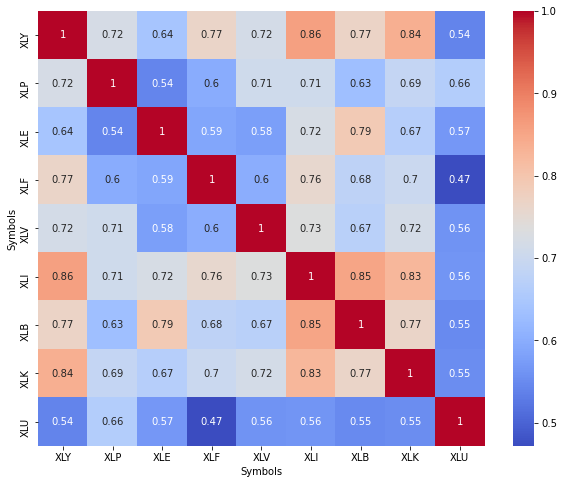

In [136]:
plt.figure(figsize=(10, 8))
sns.heatmap(sector_returns.corr(), cmap='coolwarm', annot=True);

## Calculate Competing Portfolios

### Calculating GMV

In order to calculate the Global Minimum Variance portfolio, we will create a few functions. First, we will create a `portfolio_vol` function to implement this formula:
$$\sigma^2(w_a, w_b) = \sigma_A^2w_A^2 + \sigma_B^2w_B^2 + 2w_Aw_B\sigma_A\sigma_B\rho_{A,B} $$

This summarizes to a matrix multiplication shown in the function below.

Next, we will define a function to calculate the GMV.  In order to do this, we will utilize the `minimize` function from `scipy.stats`.  `minimize` will solve for the optimal weights to minimize the volatility of the portfolio.  In order to do this, we must specify:
* init_guess: set the initial guess to equal weights  
* bounds: sets bounds for each weights, can be user-defined with min_alloc and max_alloc, default is 0, 1.  
* weights_sum_to_1: the sum of all the weights must add up to 1.  

Additionally, we will use Quadratic Programming to solve this optimization problem

In [147]:
def portfolio_vol(weights, cov_mat):
    '''Calculates the portfolio volatility given a set of weights and a covariance matrix'''
    return (weights.T @ cov_mat @ weights)**0.5


def gmv(rets, cov_mat, min_alloc=0., max_alloc=1.):
    '''Calculates the optimal weights for Global Minimize Variance portfolio for a set of securities
    
    Arguments:
    rets: pd.DataFrame of returns
    cov_mat: covariance_matrix for the securities
    min_alloc: minimum bound for the weights of each security; default=0.
    max_alloc: maxmimum bound for the wieghts of each security; default=1.
    
    Returns: pd.Series of the weights for the GMV
    '''
    # count the number of securities
    n = len(rets.columns)
    # set initial guess to equal weight
    init_guess = np.repeat(1/n, n)
    # set the bounds for each security to the min and max specified
    bounds = ((min_alloc, max_alloc), ) * n
    # create the constraint that all weights must sum to 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
                       }
    # perform the optimization to minimize portfolio_vol using 'SLSQP'
    weights = minimize(portfolio_vol, 
                       init_guess,
                       args=(cov_mat),
                       method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds
                      )
    
    return pd.Series(weights.x, index=cov_mat.index)

Now that we have defined our functions we will create a rolling calcuation looking back 6 months to calculate the covariance matrix to define the weights.  This will result in a time series of GMV weights, which we will utilize in our next step.  We will assume a minimum allocation of 0% and a maximum of 33% for any individual sector.

After we create this time_series, we can plot the weighting scheme to identify changes over time.  XLU, XLP and XLV appear to be consistently large allocatons to this portfolio over time.

Lastly, we will use these weights to calculate the period returns for the GMV portfolio.

In [212]:
# Define the window to calculate the covariance matrix over: 126 trading days ~ 6 months
estimation_window = 126
# Define the number of backtest periods
backtest_periods = total_periods - estimation_window
# create a list of tuples (start, end) for each estimaton window in the backtest period
windows = [(start, start+estimation_window) for start in range(backtest_periods)]

In [203]:
# simply shorten the name of the variable
rets = sector_returns
# use list comprehension to create the weights for each window
weights = [gmv(rets.iloc[win[0]:win[1]], (rets.iloc[win[0]:win[1]]).cov()*252, max_alloc=.33) for win in windows]
# convert the list to a pd.DataFrame
weights = pd.DataFrame(weights, index=rets.iloc[estimation_window:].index, columns=rets.columns)

In [204]:
weights.head()

Symbols,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
Date,,,,,,,,,
2005-07-06,0.00000,0.33000,0.01105,0.04970,0.33000,0.00000,0.00000,0.03333,0.24591
2005-07-07,0.00000,0.33000,0.00850,0.05007,0.33000,0.00000,0.00000,0.06183,0.21960
2005-07-08,0.00000,0.33000,0.00509,0.03270,0.33000,0.00000,0.00000,0.06056,0.24165
2005-07-11,0.00000,0.33000,0.01924,0.05751,0.33000,0.00000,0.00000,0.03214,0.23111
2005-07-12,0.00000,0.33000,0.01960,0.05897,0.33000,0.00000,0.00000,0.02839,0.23304


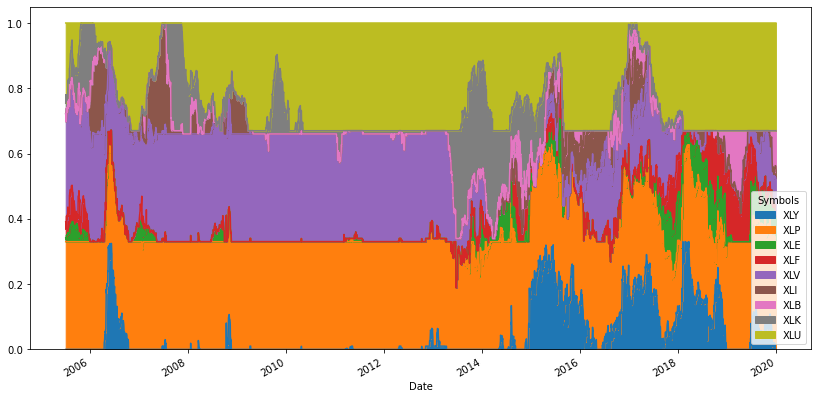

In [205]:
weights.plot.area(figsize=(14,7));

In [ ]:
# Use the weights to calculate period returns for the GMV portfolio
bt_gmv_rets = (weights * sector_returns).sum(axis='columns')

### Calculating Equal-Weight returns

Next, we will create some functions to calculate the equal-weight portfolio returns over time.  This will utilize similar functionality used above.

In [ ]:
def weight_ew(rets):
    '''Returns an equal-weight pd.Series from a list of returns'''
    n = len(rets.columns)
    return pd.Series(1/n, index=rets.columns)

def backtest(rets, estimation_window=36, weighting=weight_ew, **kwargs):
    '''Calculates returns of a weighting scheme over a defined period with a defined estimation window'''
    total_periods = rets.shape[0]
    backtest_periods = total_periods - estimation_window
    windows = [(start, start+estimation_window) for start in range(backtest_periods)]
    weights = [weighting(rets.iloc[win[0]:win[1]], **kwargs) for win in windows] 
    
    weights = pd.DataFrame(weights, index=rets.iloc[estimation_window:].index, columns=rets.columns)
    returns = (weights * rets).sum(axis="columns", min_count=1)
    
    return returns

In [215]:
# use the backtest function to calcuate equal_weight portfolio returns
bt_ew_rets = backtest(sector_returns)

### Calculating Cap-Weighted returns

Here we will simply import the prices for the 'SPY' ETF and calculate the return series over the same time period.

In [207]:
cap_wgt_prices = data.DataReader("SPY", data_source="yahoo", start="1/1/2005", end="12/31/2019")["Adj Close"]
cap_wgt_rets = cap_wgt_prices.pct_change()
cap_wgt_rets.drop(cap_wgt_rets.index[0], axis=0, inplace=True)

In [ ]:
bt_ew_rets = backtest(sector_returns)

## Evaluating the resutls.

Finally, we will compare the results.  In order to do so, we have created a variety of functions in order to do so.  Here are the metrics we will calculate:

* Annualized Returns: the compounded annualized return over the period.
    * $(1 + R_{t,t+1}) ^{n} - 1$
    
* Annualized Vol: the annualized standard deviation over the period
    * $ \sigma_R = \sqrt{\frac{1}{N}\sum_{i=1}^N(R_i - \bar{R})^2} $
    
* Sharpe Ratio: measures a unit of excess return over of the risk-free rate for each additional unit of risk.
    * $\text{Sharpe Ratio} = \frac{Return - Risk Free Rate}{Volatility} $
    
* Max Drawdown: shows the largest percentage drop in a portfolio from a previous high valuation.

* Skewness: measures the distortion from a normal distribution
    * $S(R) = \frac{E[(R - E(R))^3]}{[Var(R)^{3/2}]}$
    
* Kurtosis: measures the thickness of the tails as compared to a normal distribution
    * $K(R) = \frac{E[(R - E(R))^4]}{[Var(R)^{2}]}$
    
* Histroic VaR (5%): represents the level in which 5% of historical period losses were greater than

* Cornish-Fisher VaR: parametric calculation of Value-at-Risk, which adjusts for the skewness and kurtosis of a distribution
    * $ \tilde{z_a} = z_a + \frac{1}{6}(z_a^2 - 1)S +  \frac{1}{24}(z_a^3 - 3Z_a)(K-3) - \frac{1}{36}(2z_a^3 - 5Z_a)S^2$  

In [193]:
def annualize_rets(returns, periods_per_year=12):
    # compound each years' return at 1+r
    compounded_growth = (1+returns).prod()
    # calculate the number of periods in ind_returns
    n_periods = returns.shape[0]
    
    return compounded_growth ** (periods_per_year / n_periods) - 1


def annualize_stdev(returns, periods_per_year=12):
    
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, risk_free_rate=0, periods_per_year=12):
    # calculate the per period risk_free_rate
    rf_per_period = (1+risk_free_rate) ** (1/periods_per_year) - 1
    # calculate the excess return
    excess_ret = returns - rf_per_period
    # annualize the excess return
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    # calculate the annual volatility
    ann_sd = annualize_stdev(returns, periods_per_year)
    
    return ann_ex_ret / ann_sd

def max_drawdown(returns):
    # calculate the accumulated growth at each period
    compounded_growth = (1+returns).cumprod()
    # calculate the previous peak value at each period
    previous_peaks = compounded_growth.cummax()
    # calculate the drawdowns at each period
    drawdowns = (compounded_growth - previous_peaks) / previous_peaks
    
    return -drawdowns.min()

def skewness(returns):
    # calculate each period's return difference from the average return
    demeaned_r = returns - returns.mean()
    # calculate the standard devistion of the portfolio
    sigma_r = returns.std(ddof=0)  # using ddof=0, to calculate population standard deviation
    # caluclate the numerator in the equation
    exp = (demeaned_r**3).mean()
    
    return exp / sigma_r**3

def kurtosis(returns):
    # calculate each period's return difference from the average return
    demeaned_r = returns - returns.mean()
    # calculate the standard devistion of the portfolio
    sigma_r = returns.std(ddof=0)  # using ddof=0, to calculate population standard deviation
    # caluclate the numerator in the equation
    exp = (demeaned_r**4).mean()
    
    return exp / sigma_r**4

def var_historic(returns, level=5):
    return -np.percentile(returns, level)

def var_cornish_fisher(returns, level=5):
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    # compute the skewness
    s = skewness(returns)
    # compute the kurtosis
    k = kurtosis(returns)
    # compute the adjusted Z score
    z = (z +
                 (z**2 - 1) * s/6 +
                 (z**3 - 3*z) * (k-3)/24 -
                 (2*z**3 - 5*z) * (s**2)/36
            )
    
    return -(returns.mean() + z * returns.std(ddof=0))

def summary_stats(returns, periods_per_year=12, risk_free_rate=0.02):
    
    summary_df = pd.DataFrame({
        "Annualized Return": returns.aggregate(annualize_rets, periods_per_year=periods_per_year),
        "Annualized Vol": returns.aggregate(annualize_stdev, periods_per_year=periods_per_year),
        "Sharpe Ratio": returns.aggregate(sharpe_ratio, risk_free_rate=risk_free_rate, 
                                              periods_per_year=periods_per_year),
        "Max Drawdown": returns.aggregate(max_drawdown),
        "Skewness": returns.aggregate(skewness),
        "Kurtosis": returns.aggregate(kurtosis),
        "Historic 5% VaR": returns.aggregate(var_historic),
        "CF 5% VaR": returns.aggregate(var_cornish_fisher)
    })
    
    return summary_df

After creating this summary statistics functions, we can combine the 3 competing return series in to a DataFrame and run the view the `summary_stats`.

The GMV has competitive returns to the other 2 portfolios, with significantly lower Annualized Vol and associated Max Drawdown and VaR calculations.  Pretty impressive for a relative simple strategy.

Below we can see the visualize of these 3 portfolios.

In [209]:
returns = pd.DataFrame({
    "SPY": cap_wgt_rets["2005-08-01":],
    "EW": bt_ew_rets["2005-08-01":],
    "GMV": bt_gmv_rets["2005-08-01":]
})

summary_stats(returns, periods_per_year=252, risk_free_rate=0.01)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis,Historic 5% VaR,CF 5% VaR
SPY,0.09056,0.18581,0.42927,0.55189,0.14777,19.23411,0.01775,0.01451
EW,0.09639,0.17980,0.47573,0.52531,-0.15127,14.48108,0.01709,0.01606
GMV,0.09206,0.13515,0.60120,0.42073,-0.07637,15.67896,0.01306,0.01162


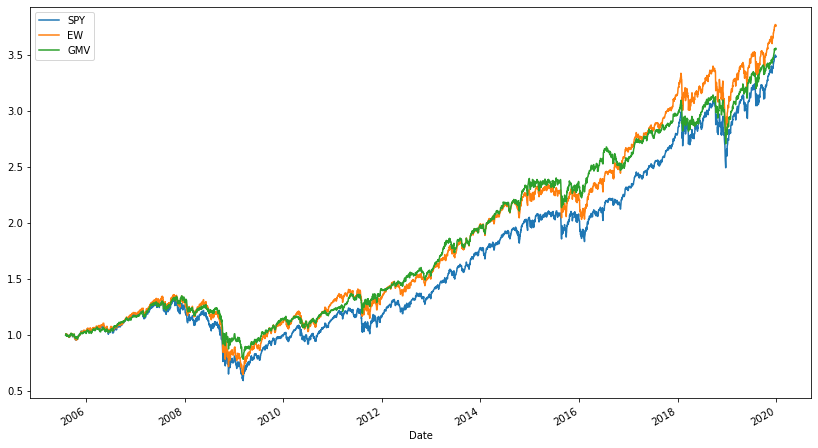

In [210]:
(1+returns).cumprod().plot(figsize=(14, 8));